In [1]:
import numpy as np
import pandas as pd
import modeling_tools as mt
import pickle
import time

import murmurhash as mhash

from IPython.display import display
%matplotlib inline

from sklearn.model_selection import ParameterGrid
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold

# vectorizers
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer

# feature selectors
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif

# scalers
from sklearn.preprocessing import MinMaxScaler

# classifiers
from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import PassiveAggressiveClassifier, Perceptron, SGDClassifier
from sklearn.linear_model import LogisticRegression

# samplers
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler



In [3]:
labeled_data = pd.read_pickle('../data/labeled_data_pos_ont_nn_ftweighted.pkl')
#drop_trash = (labeled_data['Aggr.Label'] < 90) & (labeled_data['Aggr.Label'] != 12)
#drop_trash = (labeled_data['Aggr.Label'] < 90)
drop_trash = (labeled_data['Aggr.Label'] < 90) & (labeled_data['NN_bool'] == False)
labeled_data = labeled_data[drop_trash]
labeled_data['empty'] = 0

In [4]:
def FT_to_matrix(data):
    M = np.zeros((len(data), 100))
    for index in range(len(data)):
        M[index] = data[index]
        
    return M + 2

In [5]:
pos_features = ['Adjective', 'Verb', 'Noun']
ont_features = ['Underspecified', 'Artifact', 'Object', 'Group', 'Human', 'Natural', 'LanguageRepresentation', 'Living', 'GeopoliticalPlace', 'BodyPart', 'Instrument', 'Place', '3rdOrderEntity', 'Mental', 'Purpose', 'Social', 'Institution', 'Plant', 'Imagerepresentation', 'Creature', 'Animal', 'Comestible', 'Quantity', 'Building', 'Substance', 'Part', 'Property', 'BoundedEvent', 'Agentive', 'Communication', 'Garment', 'Furniture', 'Vehicle', '1stOrderEntity', 'Covering', 'Liquid', 'Time', 'UnboundedEvent', 'Physical', 'Dynamic', 'Domain', 'Existence', 'Location', 'Manner', 'Container', 'Condition', 'Static', '2ndOrderEntity', 'Phenomenal', 'MoneyRepresentation', 'Experience', 'Relation', 'Form', 'Representation', 'Stimulating', 'Colour', 'Cause', 'Occupation', 'Possession', 'Artwork', 'Software']
numerical_features = ['Raw_len', 'Raw_word_count']
categorical_features = ['Label', 'Aggr.Label', 'Source', 'CoderId']
text_features = ['Lemma_stripped', 'Raw', 'Lemma']
fastt_features = ['Raw_FT_mean', 'Lemma_FT_mean', 'Raw_FT_weighted']
empty_features = ['empty'] # for scaling and such when only text
features = pos_features + ont_features + numerical_features + categorical_features + text_features + fastt_features + empty_features

#numerical_features = ['Raw_len', 'Raw_word_count', 'Underspecified', 'Artifact', 'Object', 'Group', 'Human', 'Natural', 'LanguageRepresentation', 'Living', 'GeopoliticalPlace', 'BodyPart', 'Instrument', 'Place', '3rdOrderEntity', 'Mental', 'Purpose', 'Social', 'Institution', 'Plant', 'Imagerepresentation', 'Creature', 'Animal', 'Comestible', 'Quantity', 'Building', 'Substance', 'Part', 'Property', 'BoundedEvent', 'Agentive', 'Communication', 'Garment', 'Furniture', 'Vehicle', '1stOrderEntity', 'Covering', 'Liquid', 'Time', 'UnboundedEvent', 'Physical', 'Dynamic', 'Domain', 'Existence', 'Location', 'Manner', 'Container', 'Condition', 'Static', '2ndOrderEntity', 'Phenomenal', 'MoneyRepresentation', 'Experience', 'Relation', 'Form', 'Representation', 'Stimulating', 'Colour', 'Cause', 'Occupation', 'Possession', 'Artwork', 'Software']
#text_features = ['Lemma_stripped', 'Lemma']
#empty_features = ['empty'] # for scaling and such when only text
#features = numerical_features + text_features + empty_features
#corpus = 'Lemma_stripped'
#fastt = 'Raw_FT_mean'
fastt = 'Raw_FT_weighted'
corpus = 'Lemma'
target = 'Aggr.Label'
#target = 'Label'

train_X, validation_X, train_y, validation_y = train_test_split(
    labeled_data[features],
    labeled_data[target],
    test_size=0.33,
    random_state=1,
    stratify=labeled_data[target])

In [7]:
class PassThrough(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def transform(self, x):
        return x

    def fit(self, x, y=None):
        return self

In [8]:
# vectorizer params
TfidfVectorizer_params = list(ParameterGrid({
    'strip_accents': ['ascii', 'unicode', None],
    'max_df': [round(0.1*x, 2) for x in range(3,11,2)] + [1],
    'max_features': [1000*x for x in range(5,50,20)] + [None],
    'norm': ['l2', None],
    'use_idf': [True, False]
}))

CountVectorizer_params = list(ParameterGrid({
    'strip_accents': ['ascii', 'unicode', None],
    'max_df': [round(0.1*x, 2) for x in range(3,11,2)] + [1],
    'max_features': [1000*x for x in range(5,50,20)] + [None],
}))

HashingVectorizer_params = list(ParameterGrid({
    'strip_accents': ['ascii', 'unicode', None],
    'n_features': [2**x for x in range(15,25,2)],
    'norm': ['l2'],
    'alternate_sign': [False]
}))

# feature selector params
SelectKBest_params = list(ParameterGrid({
    'score_func': [chi2, f_classif],
    'k': [25000,30000,35000,40000,50000]
}))

# scaler params
MinMaxScaler_params = list(ParameterGrid({
    'feature_range': [(0,1)]
}))

# classifier params
MultinomialNB_params = list(ParameterGrid({
    'alpha': [0.01, 0.0015, 0.001, 0.0005, 0.0001]
}))

LinearSVC_params = list(ParameterGrid({
    'loss': ['hinge', 'squared_hinge'],
    'tol': [0.01, 0.001, 0.0001, 0.00001],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'class_weight': ['balanced', None]
}))

ComplementNB_params = list(ParameterGrid({
    'alpha': [0.01,0.001,0.0001],
    'norm': [True, False]    
}))

SGDClassifier_params = list(ParameterGrid({
    'loss': ['hinge', 'log', 'modified_huber', 'squared_hinge'],
    'alpha': [0.1,0.01,0.001,0.0001],
    'n_jobs': [-1]
}))

# sampler params
ClusterCentroids_params = list(ParameterGrid({
    'random_state': [1],
    'sampling_strategy': ['majority', 'not minority', 'all'],
    'n_jobs': [-1]
}))

RandomUnderSampler_params = list(ParameterGrid({
    'random_state': [1],
    'sampling_strategy': ['majority', 'auto'],
    'replacement': [True, False]
}))

TomekLinks_params = list(ParameterGrid({
    'random_state': [1],
    'sampling_strategy': ['majority', 'auto'],
    'n_jobs': [-1]
}))

ADASYN_params = list(ParameterGrid({
    'random_state': [1],
    'sampling_strategy': ['minority', 'auto'],
    'n_neighbors': [3,5,7,13],
    'n_jobs': [-1]
}))

SMOTE_params = list(ParameterGrid({
    'random_state': [1],
    'sampling_strategy': ['minority', 'auto'],
    'k_neighbors': [3,5,7,13],
    'n_jobs': [-1]
}))

RandomOverSampler_params = list(ParameterGrid({
    'random_state': [1],
    'sampling_strategy': ['minority', 'auto']
}))


In [9]:
# feature combinations
feats = [
    #('TextOnly', False),
    #('TextPOS', pos_features),
    #('TextONT', ont_features),
    ('TextDLWC', numerical_features),
    #('All', pos_features + ont_features + numerical_features),
]

# vectorizers
vectorizers = [
    #('No_vectorizer', PassThrough, [{}]),
    #('TfidfVectorizer', TfidfVectorizer, [{}]),
    ('TfidfVectorizer', TfidfVectorizer, [{'max_df': 0.3, 'max_features': None, 'norm': 'l2', 'strip_accents': 'ascii', 'use_idf': False}]),
    #('TfidfVectorizer', TfidfVectorizer, TfidfVectorizer_params),
    #('CountVectorizer', CountVectorizer, CountVectorizer_params),
    #('HashingVectorizer', HashingVectorizer, HashingVectorizer_params),  
]

#corpus = ['empty']
#fastt = False

# feature selectors
selectors = [
    #('No_selector', PassThrough, [{}]),
    ('SelectKBest', SelectKBest, [{'score_func': f_classif, 'k': 35000}]),
    #('SelectKBest', SelectKBest, SelectKBest_params),
]

# scalers
scalers = [
    #('No_scaling', PassThrough, [{}]),
    ('MinMaxScaler', MinMaxScaler, [{'feature_range': (0,1)}])
    #('MinMaxScaler', MinMaxScaler, MinMaxScaler_params),
]

# classifiers
classifiers = [
    #('MultinomialNB', MultinomialNB, MultinomialNB_params),
    #('LinearSVC', LinearSVC, LinearSVC_params),
    #('ComplementNB', ComplementNB, ComplementNB_params),
    #('SGDClassifier', SGDClassifier, SGDClassifier_params)
    #('MultinomialNB', MultinomialNB, [{'alpha': 0.001}]),
    #('LinearSVC', LinearSVC, [{'C': 0.1, 'class_weight': None, 'loss': 'squared_hinge', 'tol': 0.01}]),
    #('ComplementNB', ComplementNB, [{'alpha': 0.01, 'norm': False}]),
    #('SGDClassifier', SGDClassifier, [{'alpha': 0.01, 'loss': 'hinge', 'n_jobs': -1}]),
    ('LogisticRegression', LogisticRegression, [{'solver': 'lbfgs', 'multi_class': 'multinomial'}]),
    #('XGBClassifier', XGBClassifier, [{}]),
    #('BucketClassifier', mt.BucketClassifier, [{'hashfunc': mhash, 'classifiers': [LogisticRegression(**{'solver': 'lbfgs', 'multi_class': 'multinomial'}) for _ in range(10)], 'judge': MultinomialNB(alpha=0.001), 'num_buckets': 8}]),
    #('EnsembleClassifier', mt.EnsembleClassifier, [{'binary_clf': LogisticRegression, 'binary_clf_params': {'solver': 'lbfgs'}, 'bucket_clf': MultinomialNB, 'bucket_clf_params': {'alpha': 0.001}, 'judge': MultinomialNB(alpha=0.001)}]),
]


# samplers
samplers = [
    ('SMOTE', SMOTE, [{'random_state': 1, 'sampling_strategy': 'minority', 'k_neighbors': 7, 'n_jobs': -1}]),
    #('No_sampling', PassThrough, [{}]),
    #('ClusterCentroids', ClusterCentroids, ClusterCentroids_params),
    #('RandomUnderSampler', RandomUnderSampler, RandomUnderSampler_params),
    #('TomekLinks', TomekLinks, TomekLinks_params),
    #('ADASYN', ADASYN, ADASYN_params),
    #('SMOTE', SMOTE, SMOTE_params),
    #('RandomOverSampler', RandomOverSampler, RandomOverSampler_params),
]


# run the worker functions with above configurations
results, preds_validation = mt.worker(
    train_X, train_y, validation_X, validation_y,
    vectorizers, selectors, scalers, classifiers, samplers,
    corpus, feats, fastt
)
'''
timestamp = str(round(time.time()))
results.to_pickle('../../stats/'+timestamp+'_results_features_scaling_best.pkl')
with open('../../stats/'+timestamp+'_preds_features_scaling_best.pkl', 'wb') as f:
    pickle.dump(preds_validation, f, pickle.HIGHEST_PROTOCOL)
'''
display(results.sort_values(by=['Accuracy', 'Precision'], ascending=False))

0_TextDLWC/TfidfVectorizer/LogisticRegression/SMOTE/SelectKBest/MinMaxScaler
{'max_df': 0.3, 'max_features': None, 'norm': 'l2', 'strip_accents': 'ascii', 'use_idf': False}
{'solver': 'lbfgs', 'multi_class': 'multinomial'}
{'random_state': 1, 'sampling_strategy': 'minority', 'k_neighbors': 7, 'n_jobs': -1}
{'score_func': <function f_classif at 0x000001853B9F5C80>, 'k': 35000}
{'feature_range': (0, 1)}


C:\Users\nils\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.510344121261778 0.5038237178879639 0.45310802636231723 0.4684498606629169


,Features,Vectorizer,V.params,Selector,Sel.params,Scaler,Sca.params,Classifier,C.params,Sampler,S.params,Accuracy,Precision,Recall,Fscore
0_TextDLWC/TfidfVectorizer/LogisticRegression/SMOTE/SelectKBest/MinMaxScaler,TextDLWC,TfidfVectorizer,"{'max_df': 0.3, 'max_features': None, 'norm': ...",SelectKBest,{'score_func': <function f_classif at 0x000001...,MinMaxScaler,"{'feature_range': (0, 1)}",LogisticRegression,"{'solver': 'lbfgs', 'multi_class': 'multinomial'}",SMOTE,"{'random_state': 1, 'sampling_strategy': 'mino...",0.510344,0.503824,0.453108,0.46845


In [ ]:
timestamp = str(round(time.time()))
results.to_pickle('../../stats/'+timestamp+'_results_selectors.pkl')
with open('../../stats/'+timestamp+'_preds_selectors.pkl', 'wb') as f:
    pickle.dump(preds_validation, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
misclassified = preds_validation['validation_y'] != preds_validation['preds'][0]
correctly = preds_validation['validation_y'] == preds_validation['preds'][0]

validation_X[corpus][misclassified].sample(n=5).values

In [ ]:
loaded_results = pd.read_pickle('../../stats/1571607882_results_POSandONT_MultinomialNB_best_TfidfVectorizer_best.pkl')

with open('../../stats/1571607882_preds_POSandONT_MultinomialNB_best_TfidfVectorizer_best.pkl', 'rb') as f:
    loaded_preds_validation = pickle.load(f)

display(loaded_results.sort_values(by=['Precision','Accuracy'], ascending=False))

In [ ]:
loaded_results.sort_values(by=['Precision','Accuracy'], ascending=False).groupby('Sampler').head(2)

(24, 24)


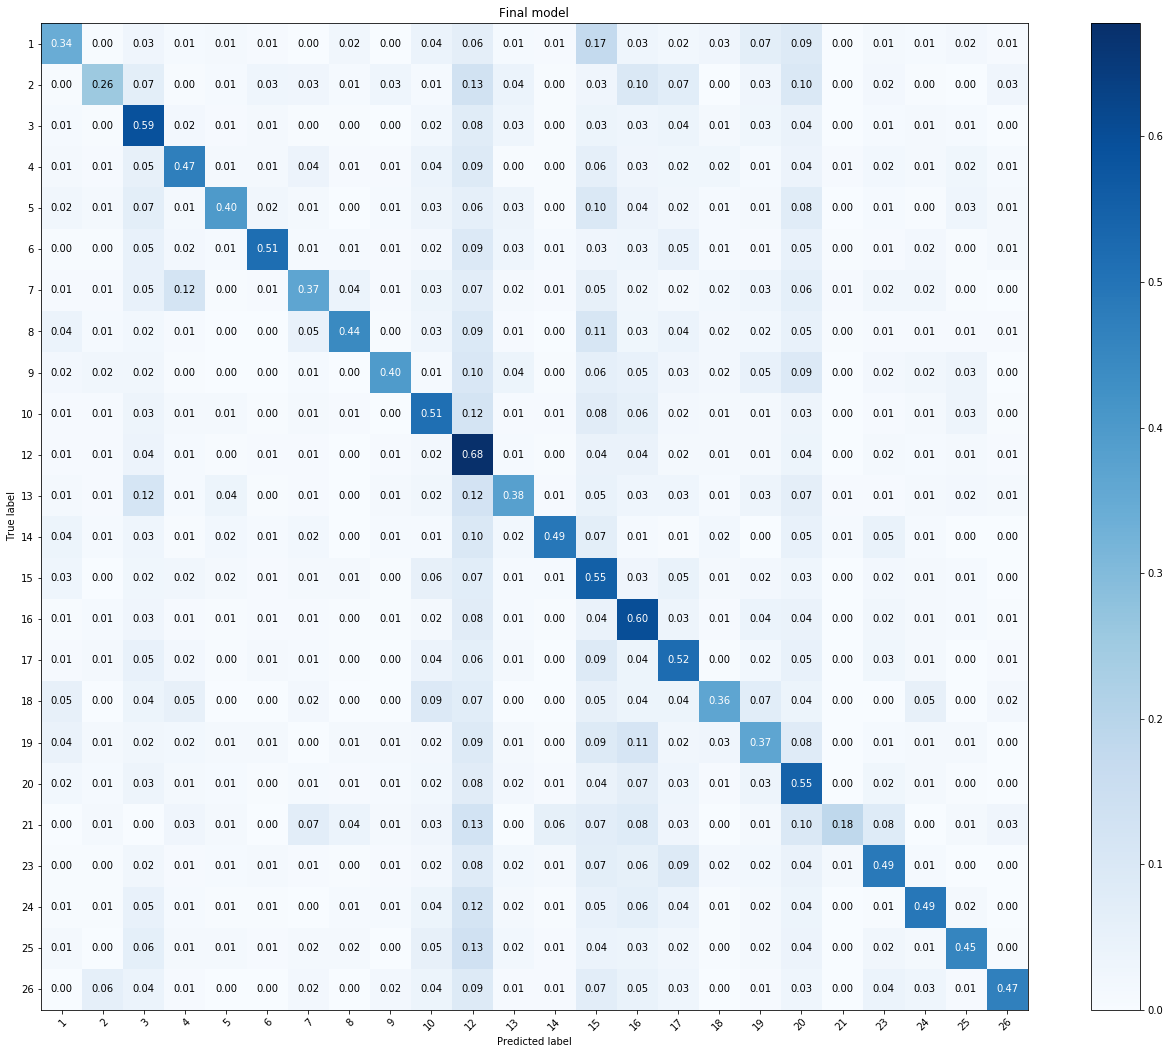

In [11]:
testy = mt.plot_cf(preds_validation['validation_y'], preds_validation['preds'][0], title = 'Final model')